# Colab Init

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/radistoubalidis/JSRepair.git

!python -m pip install lightning
!pip install datasets
!pip install python-dotenv
!pip install rouge-score
!pip install diff-match-patch

In [ ]:
%cd ./JSRepair

# Dependencies

In [1]:
from transformers import RobertaTokenizer
from modules.models import CodeT5
from modules.datasets import CodeT5Dataset
from modules.filters import add_labels
from torch.utils.data import DataLoader
from lightning import Trainer as plTrainer
from modules.filters import add_labels, count_comment_lines
from diff_match_patch import diff_match_patch
import matplotlib.pyplot as plt
import os
import sqlite3
import pandas as pd
import numpy as np
import os
import torch
import random

In [4]:
HF_DIR = 'Salesforce/codet5-base'
TOKENIZER_MAX_LENGTH = 512
DB_PATH = 'commitpack-datasets.db' if os.path.exists('commitpack-datasets.db') else '/content/drive/MyDrive/Thesis/commitpack-datasets.db'
if not os.path.exists(DB_PATH):
    raise RuntimeError('sqlite3 path doesnt exist.')
LOG_PATH = 'logs' if os.path.exists('logs') else '/content/drive/MyDrive/Thesis/logs'
LOAD_FROM_CPKT = input("Load from existing model (type cpkt path if true): ")
VERSION = LOAD_FROM_CPKT.split('.')[0].split('_')[-1]
DEBUG = True if int(input('Debug Run (1,0): ')) == 1 else False
DROPOUT_RATE = float(input('Type dropout rate for classifier: '))
WITH_LAYER_NORM = True
WITH_ACTIVATION = True
BIMODAL_TRAIN = True if int(input('Combine commit messages with codes (1,0): ')) == 1 else False

classLabels = {
    "functionality" : 0.,
    "ui-ux" : 0.,
    "compatibility-performance" : 0.,
    "network-security" : 0.,
    "general": 0.
}

num_classes = len(classLabels.keys())

modelSize = HF_DIR.split('/')[-1]
MODEL_DIR = f"CodeT5_{modelSize}_JS_{num_classes}_classes_{TOKENIZER_MAX_LENGTH}MaxL"
con = sqlite3.connect(DB_PATH)

# Testing

## Load Test Dataset

In [5]:
test_df = pd.read_sql_query('select * from commitpackft_classified_test', con)
test_df = test_df[test_df['bug_type'] != 'mobile']
test_df = test_df[test_df['old_contents'].str.len() > 0]

test_df['class_labels'] = test_df['bug_type'].apply(lambda bT: add_labels(bT, classLabels))
TEST_labels = torch.tensor(test_df['class_labels'].tolist())
if DEBUG:
    test_df = test_df.sample(10)

test_df.head()

,index,commit,old_file,new_file,old_contents,new_contents,subject,message,lang,license,repos,processed_message,is_bug,bug_type,class_labels
0,48968,4d949a2bc8f628dcc66ee62161ae3680b21766d0,bin/pep-proxy.js,bin/pep-proxy.js,#!/usr/bin/env node\n\nvar proxy = require('.....,#!/usr/bin/env node\n\nvar proxy = require('.....,FIX Move the module definition to the top of t...,FIX Move the module definition to the top of t...,JavaScript,agpl-3.0,"telefonicaid/fiware-pep-steelskin,telefonicaid...",fix move modul definit top function,1,functionality,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,21631,58c6907562ca3d4e943dfed56e795ae0a9cde762,lib/cache/lib/processUndefined.js,lib/cache/lib/processUndefined.js,"export default (doc, fields) => {\n fields....","export default (doc, fields) => {\n fields....",Fix for undefined on nested fields,Fix for undefined on nested fields\n,JavaScript,mit,cult-of-coders/redis-oplog,fix undefin nest field,1,ui-ux,"[0.0, 1.0, 0.0, 0.0, 0.0]"
2,38478,54bc7736bc5d3381a48eebba476f0933884899c6,lib/errorMessages.js,lib/errorMessages.js,"""use strict"";\n\nmodule.exports = {\n loadU...","""use strict"";\n\nmodule.exports = {\n loadU...",Clean up some error message.,Clean up some error message.\n,JavaScript,mit,YuzuJS/storeit,clean error messag,1,general,"[0.0, 0.0, 0.0, 0.0, 1.0]"
3,45690,2f3f141e1196eaa39ade102d3795cd189f57828f,src/IconMenu/IconMenu.js,src/IconMenu/IconMenu.js,import React from 'react'\nimport PropTypes fr...,import React from 'react'\nimport PropTypes fr...,Rename prop name => iconName,refactor(components): Rename prop name => icon...,JavaScript,mit,"dimik/react-material-web-components,dimik/reac...",refactorcompon renam prop name = iconnam,1,general,"[0.0, 0.0, 0.0, 0.0, 1.0]"
4,38421,bc2e4d8ebd609461c4abc63db480ae1aa5558ff7,ghost/admin/controllers/editor/new.js,ghost/admin/controllers/editor/new.js,import EditorControllerMixin from 'ghost/mixin...,import EditorControllerMixin from 'ghost/mixin...,Fix warning about transitionTo being deprecated,Fix warning about transitionTo being deprecated\n,JavaScript,mit,"TryGhost/Ghost,TryGhost/Ghost,TryGhost/Ghost",fix warn transitionto deprec,1,general,"[0.0, 0.0, 0.0, 0.0, 1.0]"


## Data Preprocessing

In [6]:
test_df['old_contents_comment_lines_count'] = test_df['old_contents'].apply(lambda sample: count_comment_lines(sample))
test_df['new_contents_comment_lines_count'] = test_df['new_contents'].apply(lambda sample: count_comment_lines(sample))

# Filter out samples where the sum of comment lines increased more than 3 lines
# to prevent excessive masking
test_df = test_df[abs(test_df['old_contents_comment_lines_count'] - test_df['new_contents_comment_lines_count']) <= 3]
# Filter out samples with more than 10 comment lines
test_df = test_df[(test_df['old_contents_comment_lines_count'] < 10) & (test_df['new_contents_comment_lines_count'] < 10)]

dmp = diff_match_patch()

def compute_diffs(sample: dict):
    # Compute the differences
    diffs = dmp.diff_main(sample['old_contents'], sample['new_contents'])
    dmp.diff_cleanupSemantic(diffs)
    # Count the changes
    return sum(1 for diff in diffs if diff[0] == 1)  # 0 means no change

test_df['num_changes'] = test_df.apply(lambda sample: compute_diffs(sample), axis=1)

# Filter out samples with more than 3 changes in the code
test_df = test_df[test_df['num_changes'] <= 3]

# filter out samples with more than 50 lines of code
test_df = test_df[(test_df['old_contents'].str.count('\n') <= 50) & (test_df['new_contents'].str.count('\n') <= 50)]

# filter out samples with more than 2 bug types
test_df = test_df[test_df['bug_type'].str.count(',') < 2]


num_samples = TEST_labels.size(0)
num_classes = TEST_labels.size(1)

test_pos_counts = torch.sum(TEST_labels, dim=0)
test_neg_counts = num_samples - test_pos_counts
test_class_weights = test_neg_counts / (test_pos_counts + 1e-6)
test_class_weights = test_class_weights.numpy()


print(f"Total test samples after filtering: {len(test_df)}")

Total test samples after filtering: 1680


In [10]:
if BIMODAL_TRAIN:
    test_df['input_seq'] = f"/* {test_df['message']}*/\n{test_df['old_contents']}"
    test_df['output_seq'] = f"/* {test_df['message']}*/\n{test_df['new_contents']}"
else:
    test_df['input_seq'] = test_df['old_contents'].copy()
    test_df['output_seq'] = test_df['new_contents'].copy()

In [7]:
model = CodeT5.load_from_checkpoint(
    LOAD_FROM_CPKT,
    class_weights=test_class_weights,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    with_activation=WITH_ACTIVATION,
    with_layer_norm=WITH_LAYER_NORM,
)

/home/disras/miniconda3/envs/thesis/lib/python3.8/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.3.3


## Tokenize Data

In [11]:
encoded_samples = model.tokenizer(
    test_df['input_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

encoded_labels = model.tokenizer(
    test_df['new_contents'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

labels = torch.tensor(test_df['class_labels'].tolist())

## Testing Script

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

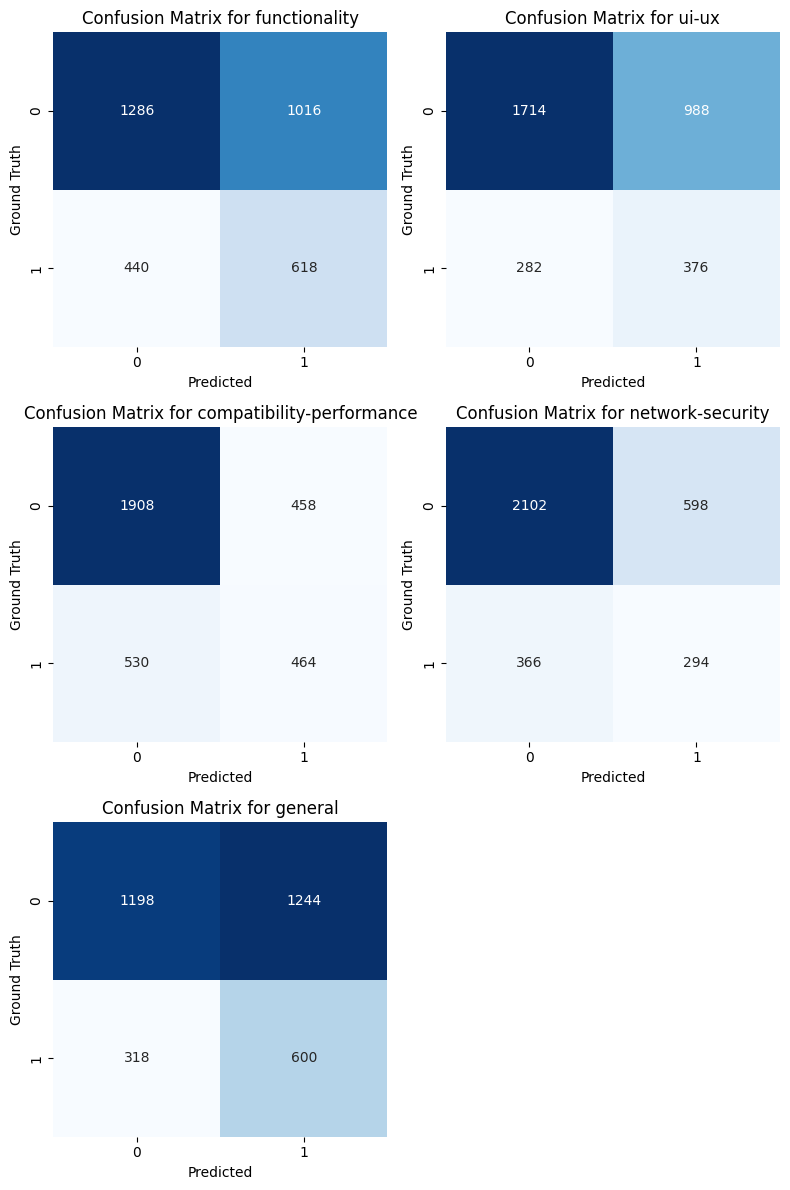

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    classification_loss    │    0.8923507928848267     │
│          t5_loss          │    0.10292903333902359    │
└───────────────────────────┴───────────────────────────┘

[{'t5_loss': 0.10292903333902359, 'classification_loss': 0.8923507928848267}]

In [19]:
METRICS_PATH = 'metrics' if os.path.exists('metrics') else '/content/drive/MyDrive/Thesis/metrics'
os.environ['METRICS_PATH'] = METRICS_PATH
os.environ['VERSION'] = str(VERSION.replace('v', '').replace('-','0'))
MODEL_NAME = 'CodeBert'
os.environ['MODEL_NAME'] = MODEL_NAME

model.eval()

torch_ds = CodeT5Dataset(encodings=encoded_samples, decodings=encoded_labels, class_labels=labels)
loader = DataLoader(torch_ds, batch_size=1, num_workers=14)

trainer = plTrainer()
trainer.test(model=model, dataloaders=loader)

## Compute Metrics

**ROUGE (Recall-Oriented understudy for Gisting Evaluation**
- A metric for evaluation text generation/sumamrization models.
- It measures the overlap between machine generated text (prediction) and its human generated corresponding text (reference)\
- [0,1] { close to 0: poor similarity, close to 1: better similarity}
- n-gram: seq of n words

Variations
- ROUGE-N : μετράει το σύνολο της επικάλυψης *[πόσες φορές εμφανίζετε στο παραγώμενο κείμενο]* το n-gram μεταξύ των προβλέψεων και του πραγματικού κειμένου

- ROUGE-N_recall : num n gram matches / num of n-gram in reference
- ROUGE-N-precision : nummber of n-gram matches / number of n gram in prediction
- ROUGE-L : Βασίζεται στο μάκρος του μεγαλύτερης κοινής υπό-ακολουθίας (Longest Common Sequence -LCS) . Υπολογίζει το μέτρο f-measure
    - ROUGE-L_recall : LCS / num words in reference
    - ROUGE-L_precision : LCS / num words in prediction

In [31]:
from modules.metrics import CodeRouge
import json

rouge = CodeRouge(['rouge7','rouge8','rouge9','rougeL','rougeLsum'])

rouge.compute(predictions=model.generated_codes, references=test_df['new_contents'].tolist())
rouge.calc_averages()

avgs_path = f"{METRICS_PATH}/{MODEL_NAME}_v{VERSION}/rouge.json"
all_path = f"{METRICS_PATH}/{MODEL_NAME}_v{VERSION}/avg_rouge.csv"
with open(avgs_path, 'a') as f:
    json.dump(rouge.avgs, f, indent=4)

all_scores = []
for r in rouge.rouge_types:
    all_scores += rouge.rouge_type_to_list(r)

metrics_df = pd.DataFrame(all_scores)

for m in ['precision','recall','fmeasure']:
    metrics_df[m] = round(metrics_df[m], 3)
metrics_df.to_csv(all_path, index=False)

RuntimeError: Can't compare lists with different lengths

## Model Comparisons

### Bar Plots

In [ ]:
codebert_avgs = rouge.avgs

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model_path.split('/')[-2]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)


plot_data = {
    f"{MODEL_NAME}_v{VERSION}": (round(codebert_avgs['avg_rouge7'].fmeasure, 5), round(codebert_avgs['avg_rouge8'].fmeasure, 5), round(codebert_avgs['avg_rouge9'].fmeasure, 5), round(codebert_avgs['avg_rougeL'].fmeasure, 5), round(codebert_avgs['avg_rougeLsum'].fmeasure, 5)),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}

metric_types = ('Rouge-7', 'Rouge-8','Rouge-9', 'Rouge-L', 'Rouge-Lsum')
x = np.arange(len(metric_types))
width = 0.15
multiplier = 0

fix, ax = plt.subplots(layout='constrained')


for model, values in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('F-Measure Model Comparison')
ax.set_xticks(x + width, metric_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
plt.show()

### Chart

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs  # Assuming rouge is a library/function that provides average scores

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model = comparison_model_path.split('/')[-2]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)

# Define metric types (assuming same metrics for both models)
metric_types = ('Rouge-7', 'Rouge-8', 'Rouge-9', 'Rouge-L', 'Rouge-Lsum')

# Create a figure with 3 rows (subplots) and 1 column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 16))

# Data dictionaries for each metric (assuming data structure from rouge)
precision_data = {
    f"{MODEL_NAME}_v{VERSION}": (codebert_avgs['avg_rouge7'].precision, codebert_avgs['avg_rouge8'].precision, codebert_avgs['avg_rouge9'].precision, codebert_avgs['avg_rougeL'].precision, codebert_avgs['avg_rougeLsum'].precision),
    comparison_model: (codet5_avgs['avg_rouge7'][0], codet5_avgs['avg_rouge8'][0], codet5_avgs['avg_rouge9'][0], codet5_avgs['avg_rougeL'][0], codet5_avgs['avg_rougeLsum'][0]),
}
recall_data = {
    f"{MODEL_NAME}_v{VERSION}": (codebert_avgs['avg_rouge7'].recall, codebert_avgs['avg_rouge8'].recall, codebert_avgs['avg_rouge9'].recall, codebert_avgs['avg_rougeL'].recall, codebert_avgs['avg_rougeLsum'].recall),
    comparison_model: (codet5_avgs['avg_rouge7'][1], codet5_avgs['avg_rouge8'][1], codet5_avgs['avg_rouge9'][1], codet5_avgs['avg_rougeL'][1], codet5_avgs['avg_rougeLsum'][1]),
}
f1_data = {
    f"{MODEL_NAME}_v{VERSION}": (codebert_avgs['avg_rouge7'].fmeasure, codebert_avgs['avg_rouge8'].fmeasure, codebert_avgs['avg_rouge9'].fmeasure, codebert_avgs['avg_rougeL'].fmeasure, codebert_avgs['avg_rougeLsum'].fmeasure),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}


# Plot Precision (ax1)
for model, precision in precision_data.items():
    ax1.plot(metric_types, precision, label=model, marker='s')  # 's' for square marker
ax1.set_xlabel('ROUGE-N')
ax1.set_ylabel('Precision')
ax1.grid(True)

# Plot Recall (ax2)
for model, recall in recall_data.items():
    ax2.plot(metric_types, recall, label=model, marker='s')  # 'o' for circle marker
ax2.set_xlabel('ROUGE-N')
ax2.set_ylabel('Recall')
ax2.grid(True)

# Plot F1 Score (ax3)
for model, f1 in f1_data.items():
    ax3.plot(metric_types, f1, label=model, marker='s')
ax3.set_xlabel('ROUGE-N')
ax3.set_ylabel('F-measure')
ax3.grid(True)

plt.legend(loc='upper left')
plt.tight_layout()

# Save the entire figure as a single PNG
plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
ax